In [1]:
from swiper2.schedule_experiments import MemorySchedule, RegularTSchedule, MSD15To1Schedule
from swiper2.device_manager import DeviceManager
from swiper2.window_builder import WindowBuilder
from swiper2.window_manager import SlidingWindowManager
from swiper2.decoder_manager import DecoderManager
from swiper2.simulator import DecodingSimulator
import swiper2.plot as plotter

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
def draw_dag(G):
    for layer, nodes in enumerate(nx.topological_generations(G)):
        # `multipartite_layout` expects the layer as a node attribute, so add the
        # numeric layer value as a node attribute
        for node in nodes:
            G.nodes[node]["layer"] = layer

    # Compute the multipartite_layout using the "layer" node attribute
    pos = nx.multipartite_layout(G, subset_key="layer")

    nx.draw_networkx(G, pos=pos)

# Sliding Window Scheme

## Regular T Schedule

In [3]:
d=7
decoding_time = 2*d
speculation_time = 100*d
# speculation_time = 100*d
speculation_time = 0
speculation_accuracy = 0

In [4]:
memory_schedule = RegularTSchedule(3, 2)
# memory_schedule = MemorySchedule(10 * d)
manager = DeviceManager(d, memory_schedule.schedule)
sliding_manager = SlidingWindowManager(WindowBuilder(d, enforce_alignment=False))
decoder_manager = DecoderManager(lambda _: decoding_time, speculation_time, speculation_accuracy, speculation_mode='separate')
# decoder_manager = DecoderManager(lambda _: decoding_time, speculation_time, speculation_accuracy, speculation_mode='integrated')
instruction_idx_range = set(range(len(memory_schedule.schedule.all_instructions)))
window_queue_history = []
windows_to_decode = 0

while not manager.is_done() or windows_to_decode > 0:
    # step device forward
    decoder_manager.step(sliding_manager.all_windows, sliding_manager.window_dag)
    fully_decoded_instructions = decoder_manager.get_finished_instruction_indices(sliding_manager.all_windows) - sliding_manager.pending_instruction_indices()

    # print(f'r {manager.current_round}, dr {decoder_manager._current_round}, decoded: {fully_decoded_instructions}')
    new_round = manager.get_next_round(fully_decoded_instructions)
    
    # process new round
    sliding_manager.process_round(new_round)
    decoder_manager.update_decoding(sliding_manager.all_windows, sliding_manager.window_dag)
    
    windows_to_decode = len(sliding_manager.all_windows) - len(decoder_manager._window_completion_times)
    window_queue_history.append(windows_to_decode)

In [5]:
decoder_manager._current_round

707

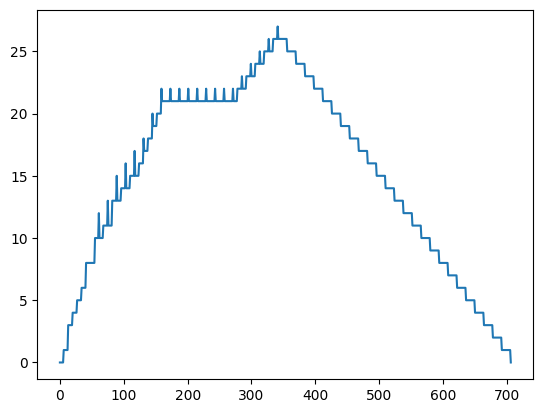

In [6]:
plt.plot(range(len(window_queue_history)), window_queue_history)
plt.show()

# Rounds: 707


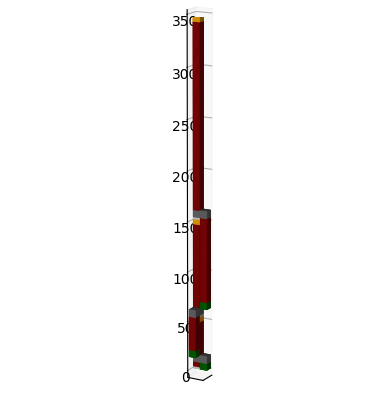

In [7]:
plotter.plot_device_schedule_trace(manager.get_data())
print(f"# Rounds: {decoder_manager._current_round}")

<Axes3D: >

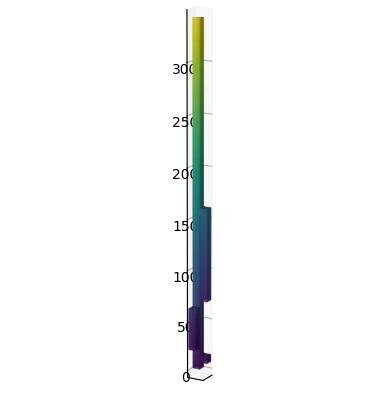

In [8]:
window_completion_times = decoder_manager.get_data().window_completion_times
plotter.plot_device_schedule_trace(
   manager.get_data(),
   windows=sliding_manager.all_windows, 
   window_schedule_times=[window_completion_times[w] for w in sliding_manager.all_windows],
)

# Doing the same thing using DecodingSimulator

In [9]:
simulator = DecodingSimulator(d, lambda _: decoding_time, speculation_time, speculation_accuracy, speculation_mode='separate')

In [10]:
device_data, window_data, decoding_data, window_queue_history = simulator.run(
    schedule=memory_schedule.schedule,
    scheduling_method='sliding',
    enforce_window_alignment=False,
    max_parallel_processes=None,
)

In [11]:
len(decoding_data.max_parallel_processes_by_round)

707

In [12]:
decoding_data

DecoderData(max_parallel_processes=None, max_parallel_processes_by_round=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 0, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 0, 6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 0, 8, 8, 8, 8, 8, 8, 10, 10, 10, 10, 10, 10, 10, 0, 9, 9, 9, 9, 9, 9, 11, 11, 11, 11, 11, 11, 11, 2, 11, 11, 11, 11, 11, 9, 12, 12, 12, 12, 12, 12, 12, 3, 12, 12, 12, 12, 12, 9, 13, 13, 13, 13, 13, 13, 13, 4, 13, 13, 13, 13, 13, 9, 14, 14, 14, 14, 14, 14, 14, 5, 15, 15, 15, 15, 15, 10, 16, 16, 16, 16, 16, 16, 16, 6, 17, 17, 17, 17, 17, 11, 18, 18, 18, 18, 18, 18, 18, 7, 19, 19, 19, 19, 19, 12, 20, 20, 20, 20, 20, 20, 20, 7, 20, 20, 20, 20, 20, 11, 20, 20, 20, 20, 20, 20, 20, 6, 20, 20, 20, 20, 20, 10, 20, 20, 20, 20, 20, 20, 20, 5, 20, 20, 20, 20, 20, 9, 20, 20, 20, 20, 20, 20, 20, 4, 20, 20, 20, 20, 20, 8, 20, 20, 20, 20, 20, 20, 20, 3, 20, 20, 20, 20, 20, 7, 20, 20, 20, 20, 20, 20, 20, 2, 20, 20, 20, 20, 20, 6, 20, 20, 20, 20, 2

<Axes3D: >

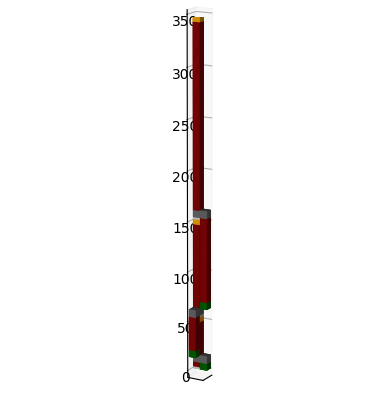

In [13]:
plotter.plot_device_schedule_trace(device_data)

<Axes3D: >

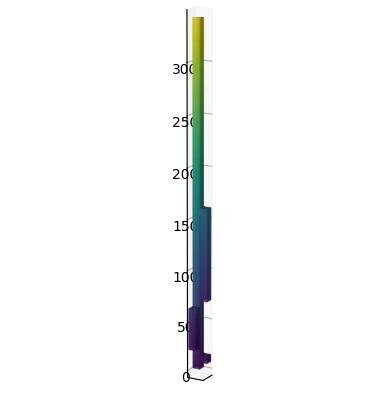

In [14]:
window_completion_times = decoding_data.window_completion_times
plotter.plot_device_schedule_trace(
    device_data,
    windows=window_data.all_windows, 
    window_schedule_times=[window_completion_times[w] for w in window_data.all_windows],
)

## 15 - 1 Factory

<font color=red>VERIFY CORRECTNESS</font>

In [15]:
d=7
decoding_time = 2*d
speculation_time = 100*d
speculation_accuracy = 0

In [16]:
simulator = DecodingSimulator(d, lambda _: decoding_time, speculation_time, speculation_accuracy, speculation_mode='separate')

In [17]:
device_data, window_data, decoding_data, window_queue_history = simulator.run(
    schedule=MSD15To1Schedule().schedule,
    scheduling_method='sliding',
    enforce_window_alignment=False,
    max_parallel_processes=None,
)

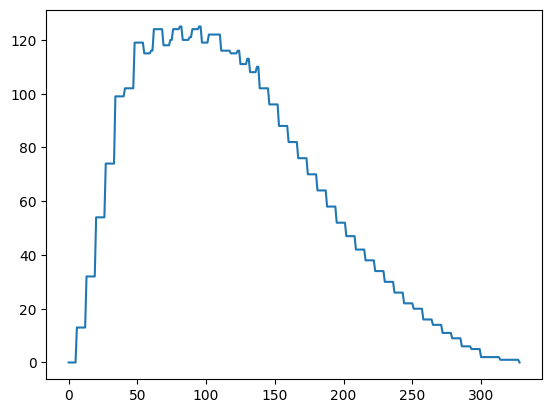

In [18]:
plt.plot(range(len(window_queue_history)), window_queue_history)
plt.show()

<Axes3D: >

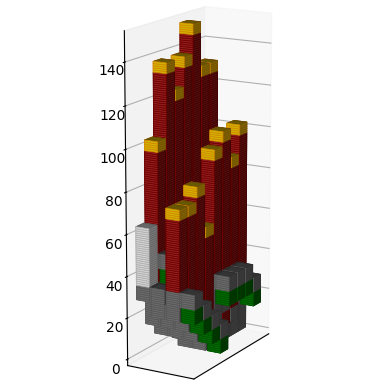

In [19]:
plotter.plot_device_schedule_trace(device_data, spacing=1)

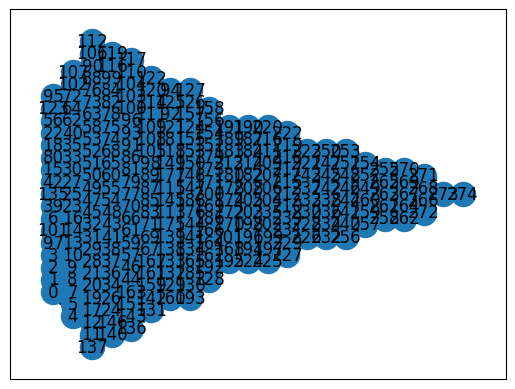

In [20]:
draw_dag(window_data.window_dag)

<Axes3D: >

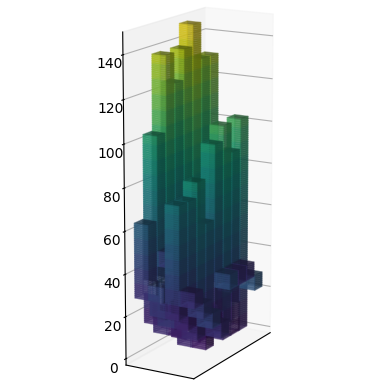

In [21]:
window_completion_times = decoding_data.window_completion_times
plotter.plot_device_schedule_trace(
    device_data,
    spacing=1,
    windows=window_data.all_windows, 
    window_schedule_times=[window_completion_times[w] for w in window_data.all_windows],
)